In [4]:
%load_ext autoreload
%autoreload 2

import argparse

import awkward as ak
import numpy as np

from python.analysis import cross_section, Tags
from python.analysis import Plots, Master
from rich import print

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
config = "work/2023/cex_analysis_1GeV_config.json"
args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration(config))
cross_section.SetPlotStyle(True, dpi = 100)

In [7]:
def ComputeQuantities(events : Master.Data, mc : bool, args : argparse.Namespace):
    reco_upstream_loss = cross_section.UpstreamEnergyLoss(cross_section.KE(events.recoParticles.beam_inst_P, cross_section.Particle.from_pdgid(211).mass), args.upstream_loss_correction_params["value"])
    
    reco_KE_ff = cross_section.KE(events.recoParticles.beam_inst_P, cross_section.Particle.from_pdgid(211).mass) - reco_upstream_loss
    reco_KE_int = reco_KE_ff - cross_section.RecoDepositedEnergy(events, reco_KE_ff, "bb")
    reco_track_length = events.recoParticles.beam_track_length

    if mc is True:
        true_KE_ff = events.trueParticles.beam_KE_front_face
        true_KE_int = events.trueParticles.beam_traj_KE[:, -2]
        true_track_length = events.trueParticles.beam_track_length
    else:
        true_KE_ff = None
        true_KE_int = None
        true_track_length = None

    return {
        "reco" : {"KE_init" : reco_KE_ff, "KE_int" : reco_KE_int, "z_int" : reco_track_length},
        "true" : {"KE_init" : true_KE_ff, "KE_int" : true_KE_int, "z_int" : true_track_length}
    }

samples = {
    "mc" : Master.Data(args.mc_file, -1, nTuple_type = Master.Ntuple_Type(args.ntuple_type)),
    "data" : Master.Data(args.data_file, -1, nTuple_type = Master.Ntuple_Type(args.ntuple_type))
}


quantities = {
    "mc" : ComputeQuantities(samples["mc"], True, args),
    "data" : ComputeQuantities(samples["data"], False, args),
    }

print(quantities)

# beam_mask = {
#     "mc" : SelectionTools.CombineSelections(samples["mc"], args.beam_selection["selections"].values(), 0, args.beam_selection["mc_arguments"].values()),
#     "data" : SelectionTools.CombineSelections(samples["data"], args.beam_selection["selections"].values(), 0, args.beam_selection["data_arguments"].values())
# }

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in power
  result = getattr(ufunc, method)(


{
    'mc': {
        'reco': {
            'KE_init': <Array [739, 955, 800, 905, ... 893, 823, 815] type='298194 * float64'>,
            'KE_int': <Array [713, 681, 645, 905, ... 849, 823, 815] type='298194 * float64'>,
            'z_int': <Array [11.9, 125, 71.4, 0, ... 21, 20.1, 0, 0] type='298194 * float64'>
        },
        'true': {
            'KE_init': <Array [788, 897, 368, 879, ... 418, 415, 403] type='298194 * ?float64'>,
            'KE_int': <Array [762, 637, 1.76, 824, ... 386, 411, 402] type='298194 * float64'>,
            'z_int': <Array [11.5, 122, 71.1, 27.7, ... 11, 0, 0] type='298194 * float64'>
        }
    },
    'data': {
        'reco': {
            'KE_init': <Array [828, 712, ... -1.22e+08, -1.22e+08] type='1215251 * float64'>,
            'KE_int': <Array [760, 294, 889, 681, ... 0, 0, 0, 0] type='1215251 * float64'>,
            'z_int': <Array [31.2, 197, 68.6, ... 7.15, 9.99, 17] type='1215251 * float64'>
        },
        'true': {'KE_init': None, 'KE_int': None, 'z_int': None}
    }
}

In [34]:
def GetTotalPionInelMasks(samples : dict[Master.Data]) -> ak.Array:
    particle_tags = Tags.GenerateTrueBeamParticleTags(samples["mc"])
    return particle_tags["$\\pi^{+}$:inel"].mask


def GetTotalPionCounts(pion_mask : ak.Array, quantities : dict[str, ak.Array], bins : dict[str, np.array], ranges : dict[str, list]) -> np.array:
    counts = {q : np.histogram(np.array(quantities[q][pion_mask]), bins[q], range = ranges[q])[0] for q in quantities}
    return counts


def FilterSamples(samples, mask):
    for s in samples:
        samples[s].Filter([mask[s]], [mask[s]])


def FilterQuantities(quantities, mask):
    for m in mask:
        for data_type in quantities[m]:
            for q in quantities[m][data_type]:
                if quantities[m][data_type][q] is not None:
                    quantities[m][data_type][q] = quantities[m][data_type][q][mask[m]]
    return quantities


def Efficiency(selected_count : np.array, total_count : np.array) -> tuple[np.array, np.array]:
    p = selected_count / total_count
    p = np.nan_to_num(p)
    error = (p * (1 - p) / total_count)**0.5
    return p, error


def plot_params(params : dict, initial_pion_counts : np.array, bins : np.array, tags : Tags.Tags, x_range : list, x_label : str):
    # efficiency_initial = Efficiency(np.histogram(np.array(params["mc"][mask][tags["$\\pi^{+}$:inel"].mask]), bins, range = x_range)[0], np.histogram(np.array(params[initial_pions]), bins, range = x_range)[0])
    e = Efficiency(
        np.histogram(np.array(params["mc"][tags["$\\pi^{+}$:inel"].mask]), bins, range = x_range)[0],
        initial_pion_counts
    )

    Plots.PlotTagged(params["mc"], tags, data2 = params["data"], bins = bins, x_range = x_range, x_label = x_label, norm = args.norm)
    Plots.Plot((bins[1:] + bins[:-1])/2, e[0], yerr = e[1], xlabel = x_label, ylabel = "Cumulative $\pi^{+}:inel$ efficiency")


def plot_all_params(mask : dict):
    particle_tags = Tags.GenerateTrueBeamParticleTags(samples["mc"])
    # initial_inelastic = ak.Array(particle_tags["$\\pi^{+}$:inel"].mask)
    # for p in particle_tags:
    #     particle_tags[p].mask = particle_tags[p].mask[mask["mc"]]

    for q in labels:
        data = {s : quantities[s]["reco"][q] for s in samples}

        plot_params(data, initial_pion_counts[q], bins[q], particle_tags, ranges[q], labels[q])
    Plots.plt.show()


ranges = {
    "KE_init" : [0, 1250],
    "KE_int" : [0, 1250],
    "z_int" : [0, 500]
}
bins = {r : np.linspace(min(ranges[r]), max(ranges[r]), 50) for r in ranges}
labels = {
    "KE_init" : "$KE^{reco}_{ff}$ (MeV)",
    "KE_int" : "$KE^{reco}_{int}$ (MeV)",
    "z_int" : "$l^{reco}$ (cm)"
}

initial_pion_inel_mask = GetTotalPionInelMasks(samples)
initial_pion_counts = GetTotalPionCounts(initial_pion_inel_mask, quantities["mc"]["reco"], bins, ranges)

# print("no selection")
# mask = {s : samples[s].eventNum > 0 for s in samples}
# plot_all_params(mask)

for s in args.selection_masks["data"]["beam"]:
    mask = {i : args.selection_masks[i]["beam"][s] for i in samples}

    print(s)
    for m in mask:
        print(m, ak.count(mask[m]), ak.sum(mask[m]))

    FilterQuantities(quantities, mask)
    FilterSamples(samples, mask)
    # plot_all_params(mask)

PiBeamSelection

mc 298194 170238

data 1215251 119545

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


CaloSizeCut

mc 170238 146397

data 119545 104581

PandoraTagCut

mc 146397 142362

data 104581 100150

DxyCut

mc 142362 115894

data 100150 80160

DzCut

mc 115894 106545

data 80160 77612

CosThetaCut

mc 106545 101106

data 77612 71821

APA3Cut

mc 101106 82306

data 71821 54887

MichelScoreCut

mc 82306 80731

data 54887 53613

MedianDEdXCut

mc 80731 77218

data 53613 50588

BeamScraperCut

mc 77218 50805

data 50588 33385

In [47]:
def CreatePFOMasks(masks : dict):
    mask = None
    for m in masks:
        if mask is None:
            mask = masks[m]
        else:
            mask = mask & masks[m]
    return mask

pi = {s : CreatePFOMasks(args.selection_masks[s]["pi"]) for s in samples}
pi0 = {s : CreatePFOMasks(args.selection_masks[s]["pi0"]) for s in samples}

n_pi = {s : ak.sum(pi[s], -1) for s in samples}
n_pi0 = {s : ak.sum(pi0[s], -1) for s in samples}

n_pi_true = samples["mc"].trueParticles.nPiPlus + samples["mc"].trueParticles.nPiMinus
n_pi0_true = samples["mc"].trueParticles.nPi0

print(f"{n_pi_true=}")
print(f"{n_pi0_true=}")

n_pi_true=<Array [2, 0, 2, 1, 1, 0, ... 0, 0, 0, 1, 1, 1] type='50805 * int32'>

n_pi0_true=<Array [0, 1, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='50805 * int32'>

pdf 1GeV_MC_region_plots has been opened
pdf 1GeV_MC_region_plots has been closed


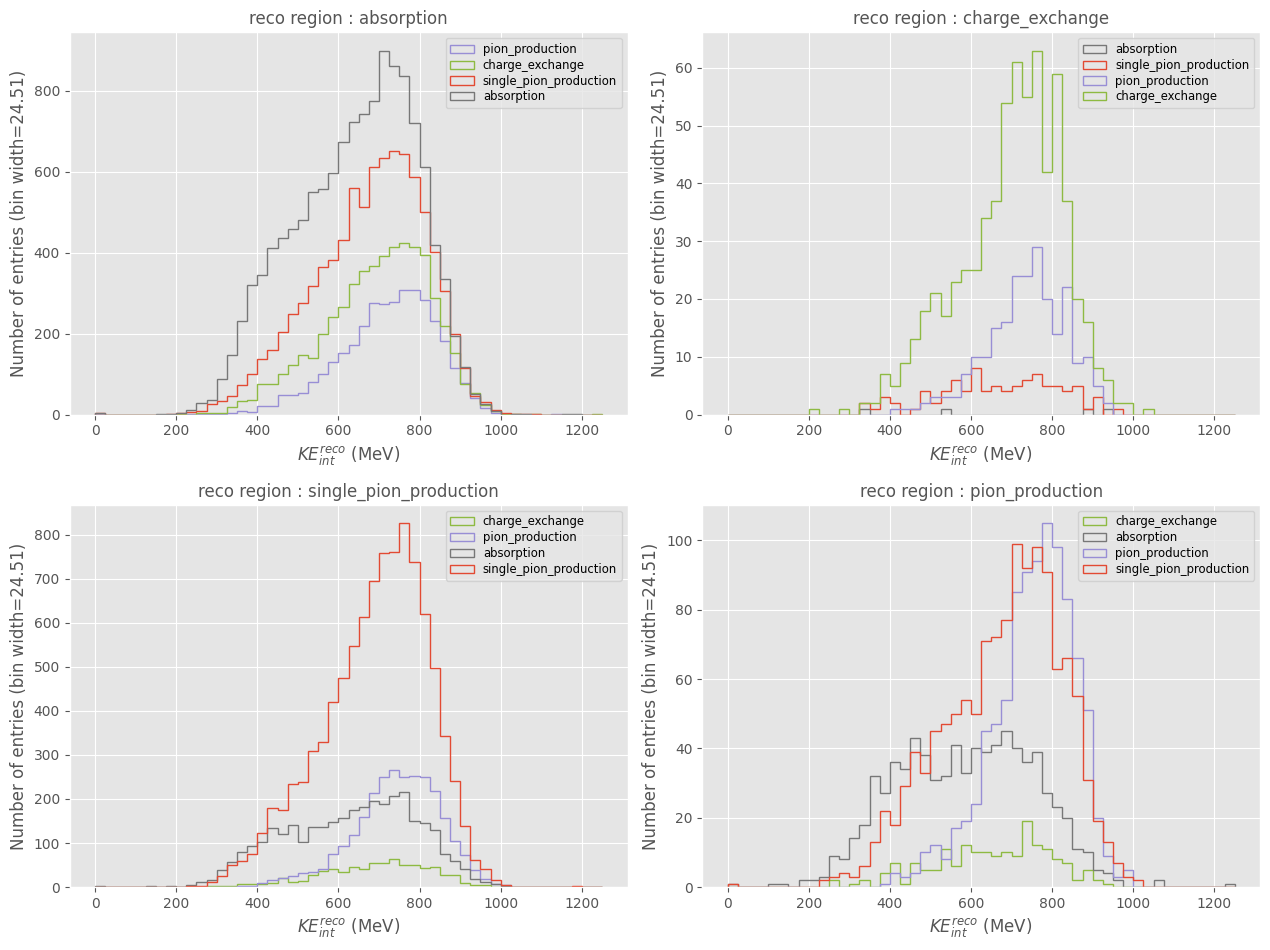

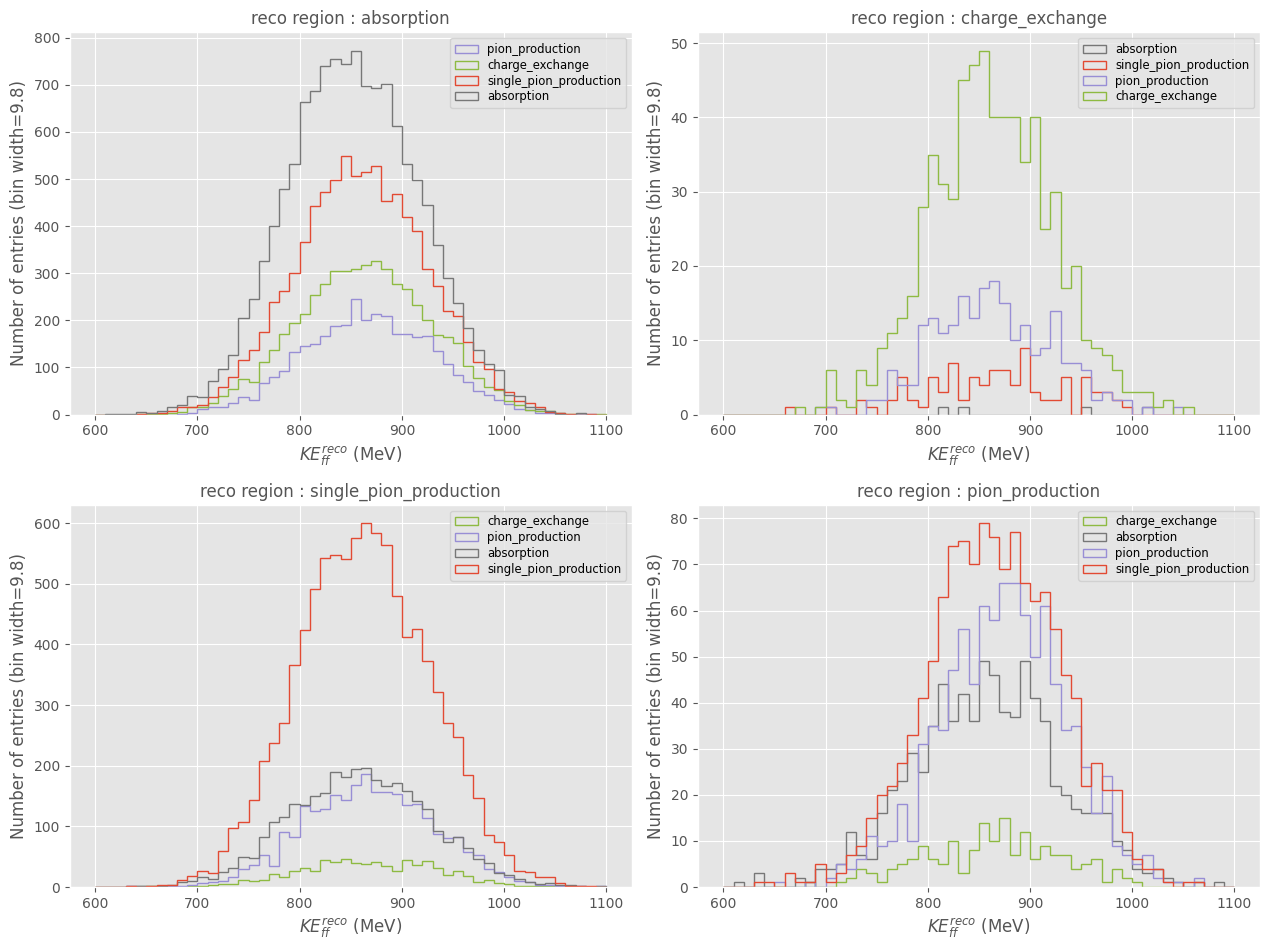

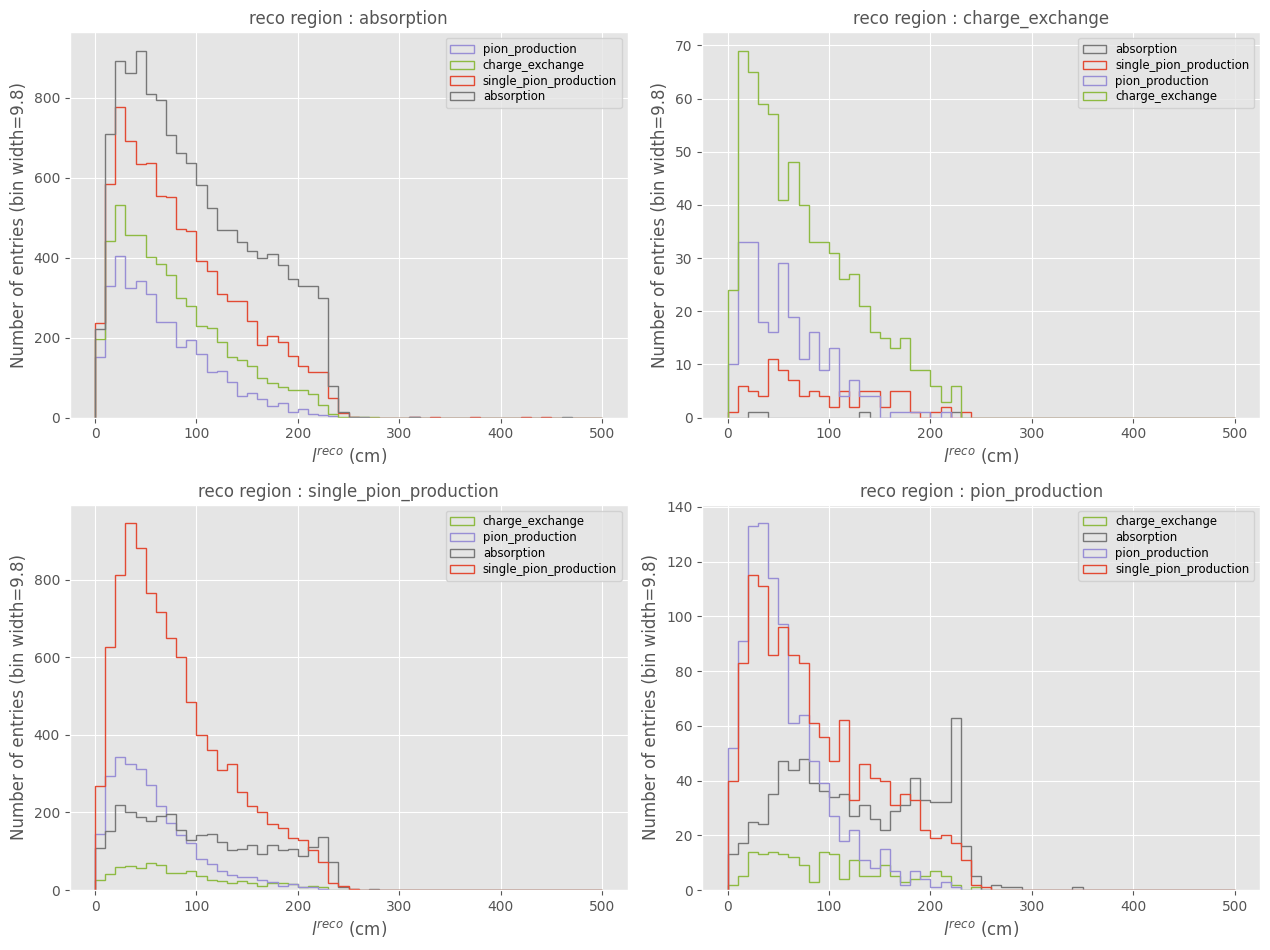

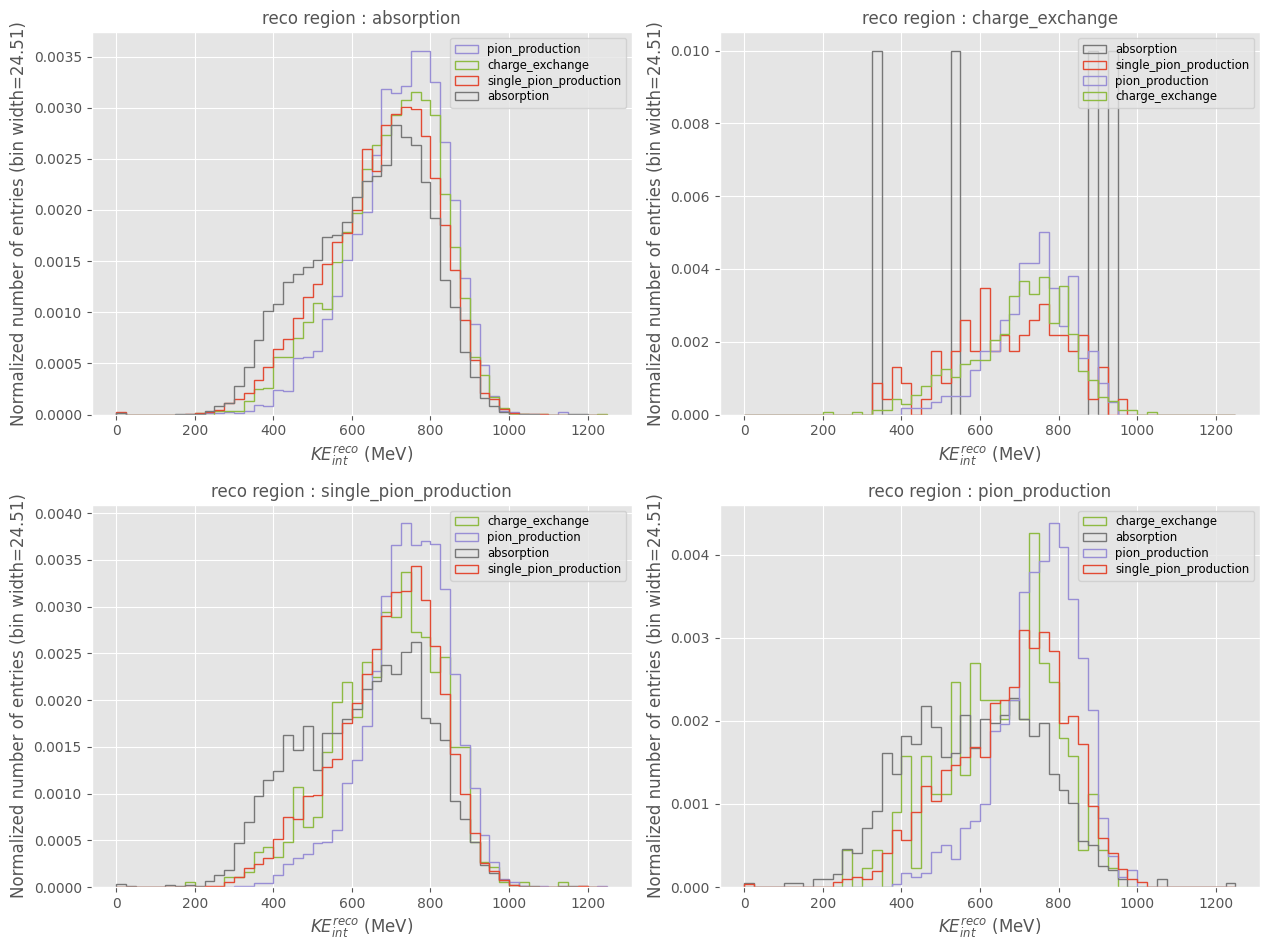

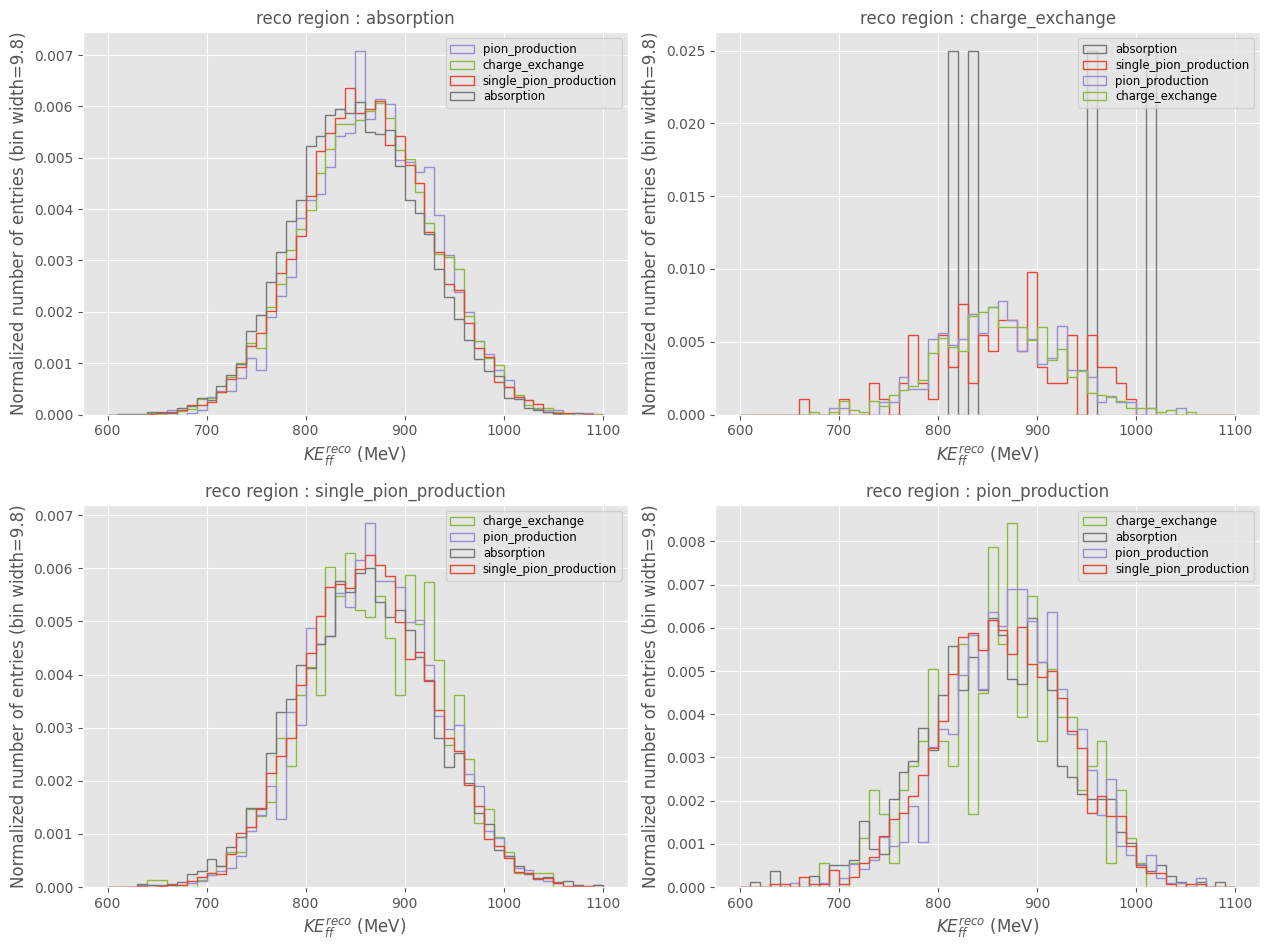

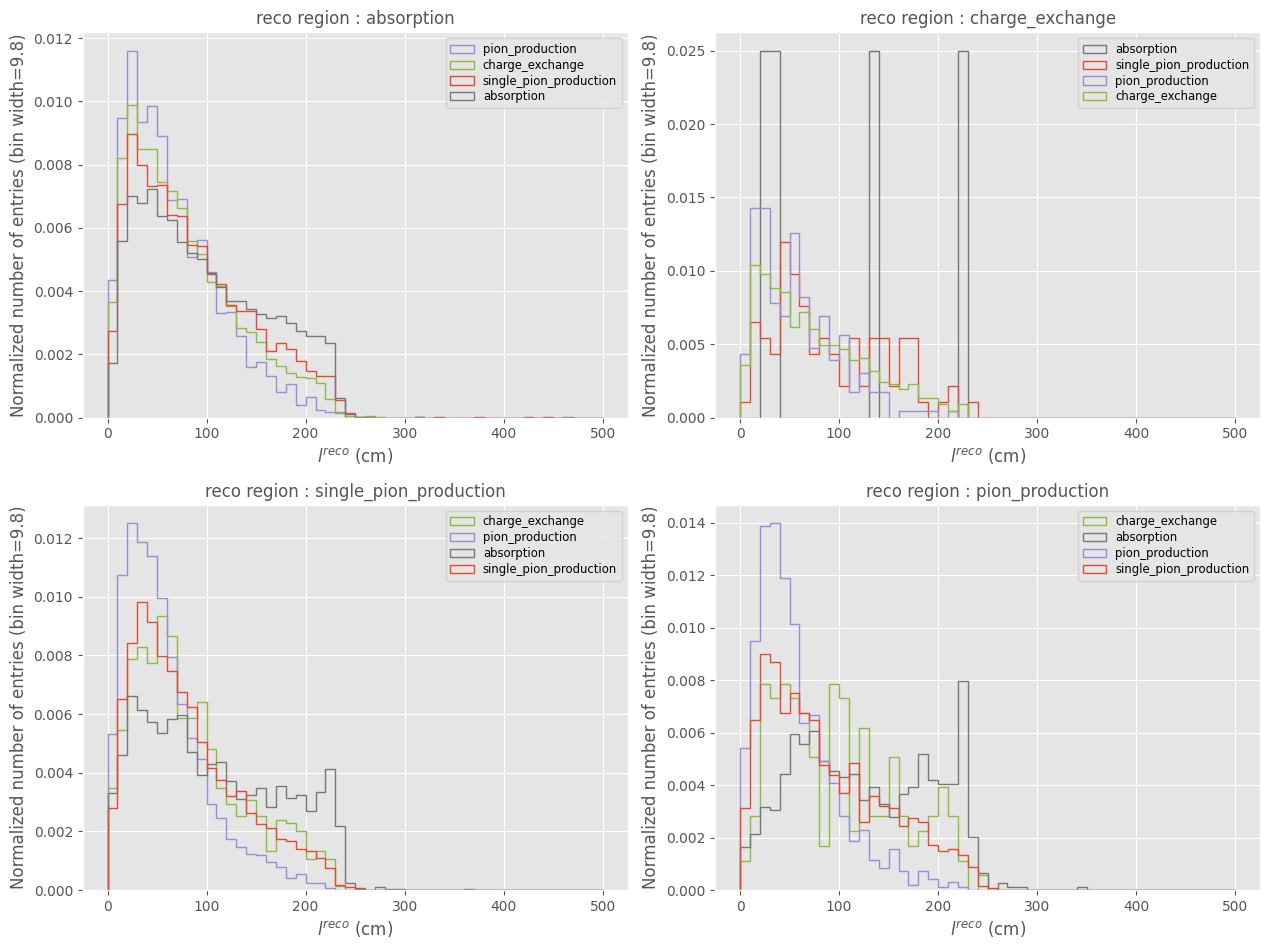

In [63]:
def PlotObservablesInRegions(observable, reco_regions, true_regions, label, x_range, norm : bool = False):
    for _, r in Plots.IterMultiPlot(reco_regions):
        tmp_regions = {t : true_regions[t][reco_regions[r]] for t in true_regions} # filter the reco events for this region only
        Plots.PlotTagged(observable[reco_regions[r]], Tags.ExclusiveProcessTags(tmp_regions), bins = 50, newFigure = False, title = f"reco region : {r}", reverse_sort = False, stacked = False, histtype = "step", x_label = label, x_range = x_range, ncols = 1, norm = norm)
    pdf.Save()

regions = {s : cross_section.EventSelection.create_regions_new(n_pi0[s], n_pi[s]) for s in samples}
true_regions = cross_section.EventSelection.create_regions_new(n_pi0_true, n_pi_true)

pdf = Plots.PlotBook("1GeV_MC_region_plots", open = True)

PlotObservablesInRegions(quantities["mc"]["reco"]["KE_int"], regions["mc"], true_regions, labels["KE_int"], x_range = ranges["KE_int"])
PlotObservablesInRegions(quantities["mc"]["reco"]["KE_init"], regions["mc"], true_regions, labels["KE_init"], x_range = [600, 1100])
PlotObservablesInRegions(quantities["mc"]["reco"]["z_int"], regions["mc"], true_regions, labels["z_int"], x_range = ranges["z_int"])

PlotObservablesInRegions(quantities["mc"]["reco"]["KE_int"], regions["mc"], true_regions, labels["KE_int"], x_range = ranges["KE_int"], norm = True)
PlotObservablesInRegions(quantities["mc"]["reco"]["KE_init"], regions["mc"], true_regions, labels["KE_init"], x_range = [600, 1100], norm = True)
PlotObservablesInRegions(quantities["mc"]["reco"]["z_int"], regions["mc"], true_regions, labels["z_int"], x_range = ranges["z_int"], norm = True)
pdf.close()

In [10]:
def FitlerTags(tags, mask):
    for r in tags:
        tags[r].mask = tags[r].mask & mask
    return tags

def UpdateTags(tags, mask):
    for r in tags:
        tags[r].mask = tags[r].mask[mask]
    return tags

regions = {s : cross_section.EventSelection.create_regions(ak.sum(pi0[s], axis = -1), ak.sum(pi[s], axis = -1)) for s in samples} # plot varaibles stacked in regions
# regions.pop("pion_prod_>1_pi0")

In [28]:
def PlotInRegions(param, regions, bins, x_range, x_label, stacked : bool = True, norm : bool = True, blind : bool = True):
    for _, r in Plots.IterMultiPlot(regions["mc"], sharex = True, sharey = True):
        tags = UpdateTags(cross_section.EventSelection.GenerateTrueFinalStateTags(samples["mc"]), regions["mc"][r])
        if stacked is True:
            histtype = "bar"
        else:
            histtype = "step"
        Plots.PlotTagged(param["mc"][regions["mc"][r]], tags, data2 = None if blind else param["data"][regions["data"][r]], title = r, newFigure = False, stacked = stacked, bins = bins, histtype = histtype, x_label = x_label, x_range = x_range, norm = norm, ncols = 1)


def PlotTaggedNormalisedError(param, regions, bins, range, label, blind : bool = True):
    for _, r in Plots.IterMultiPlot(regions["mc"]):
        tags = UpdateTags(cross_section.EventSelection.GenerateTrueFinalStateTags(samples["mc"]), regions["mc"][r])

        for tag in tags.values():
            counts, edges = np.histogram(np.array(param["mc"][regions["mc"][r]][tag.mask]), bins = bins, range = range, density = False)
            centers = (edges[1:] + edges[:-1])/2

            density = counts / (sum(counts) * np.diff(edges))
            density_err = np.sqrt(counts) / (sum(counts) * np.diff(edges))

            Plots.Plot(centers, density, yerr = density_err, linestyle = "-", color = tag.colour, newFigure = False, label = tag.name, xlabel = label, title = r)
            # Plots.PlotHist(param[regions[r]][tag.mask], bins = edges, histtype = "step", color = tag.colour, newFigure = False, density = True, label = tag.name, xlabel = label, alpha = None, title = r)


def PlotSingleTaggedNormalisedError(param, regions, bins, range, label):
    tags = cross_section.EventSelection.GenerateTrueFinalStateTags(samples["mc"])
    for _, r in Plots.IterMultiPlot(regions["mc"]):
        data = [param["mc"][regions["mc"][r] & tags[r].mask], param["mc"][regions["mc"][r] & ~tags[r].mask]]
        signal, edges = np.histogram(np.array(data[0]), bins = bins, range = range, density = False)
        background, _ = np.histogram(np.array(data[1]), bins = bins, range = range, density = False)
        centers = (edges[1:] + edges[:-1])/2

        density = [signal / (sum(signal) * np.diff(edges)), background / (sum(background) * np.diff(edges))]
        density_err = [np.sqrt(signal) / (sum(signal) * np.diff(edges)), np.sqrt(background) / (sum(background) * np.diff(edges))]

        Plots.Plot(centers, density[0], yerr = density_err[0], linestyle = "", color = tags[r].colour, newFigure = False)
        Plots.Plot(centers, density[1], yerr = density_err[1], linestyle = "", color = "black", newFigure = False)
        Plots.PlotHistComparison(data, labels = [tags[r].name, "other"], bins = bins, title = r, colours = [tags[r].colour, "black"], xlabel = label, newFigure = False)

/tmp/ipykernel_32150/1214775617.py:19: RuntimeWarning: invalid value encountered in divide
  density = counts / (sum(counts) * np.diff(edges))
/tmp/ipykernel_32150/1214775617.py:20: RuntimeWarning: invalid value encountered in divide
  density_err = np.sqrt(counts) / (sum(counts) * np.diff(edges))
/tmp/ipykernel_32150/1214775617.py:34: RuntimeWarning: invalid value encountered in divide
  density = [signal / (sum(signal) * np.diff(edges)), background / (sum(background) * np.diff(edges))]
/tmp/ipykernel_32150/1214775617.py:35: RuntimeWarning: invalid value encountered in divide
  density_err = [np.sqrt(signal) / (sum(signal) * np.diff(edges)), np.sqrt(background) / (sum(background) * np.diff(edges))]


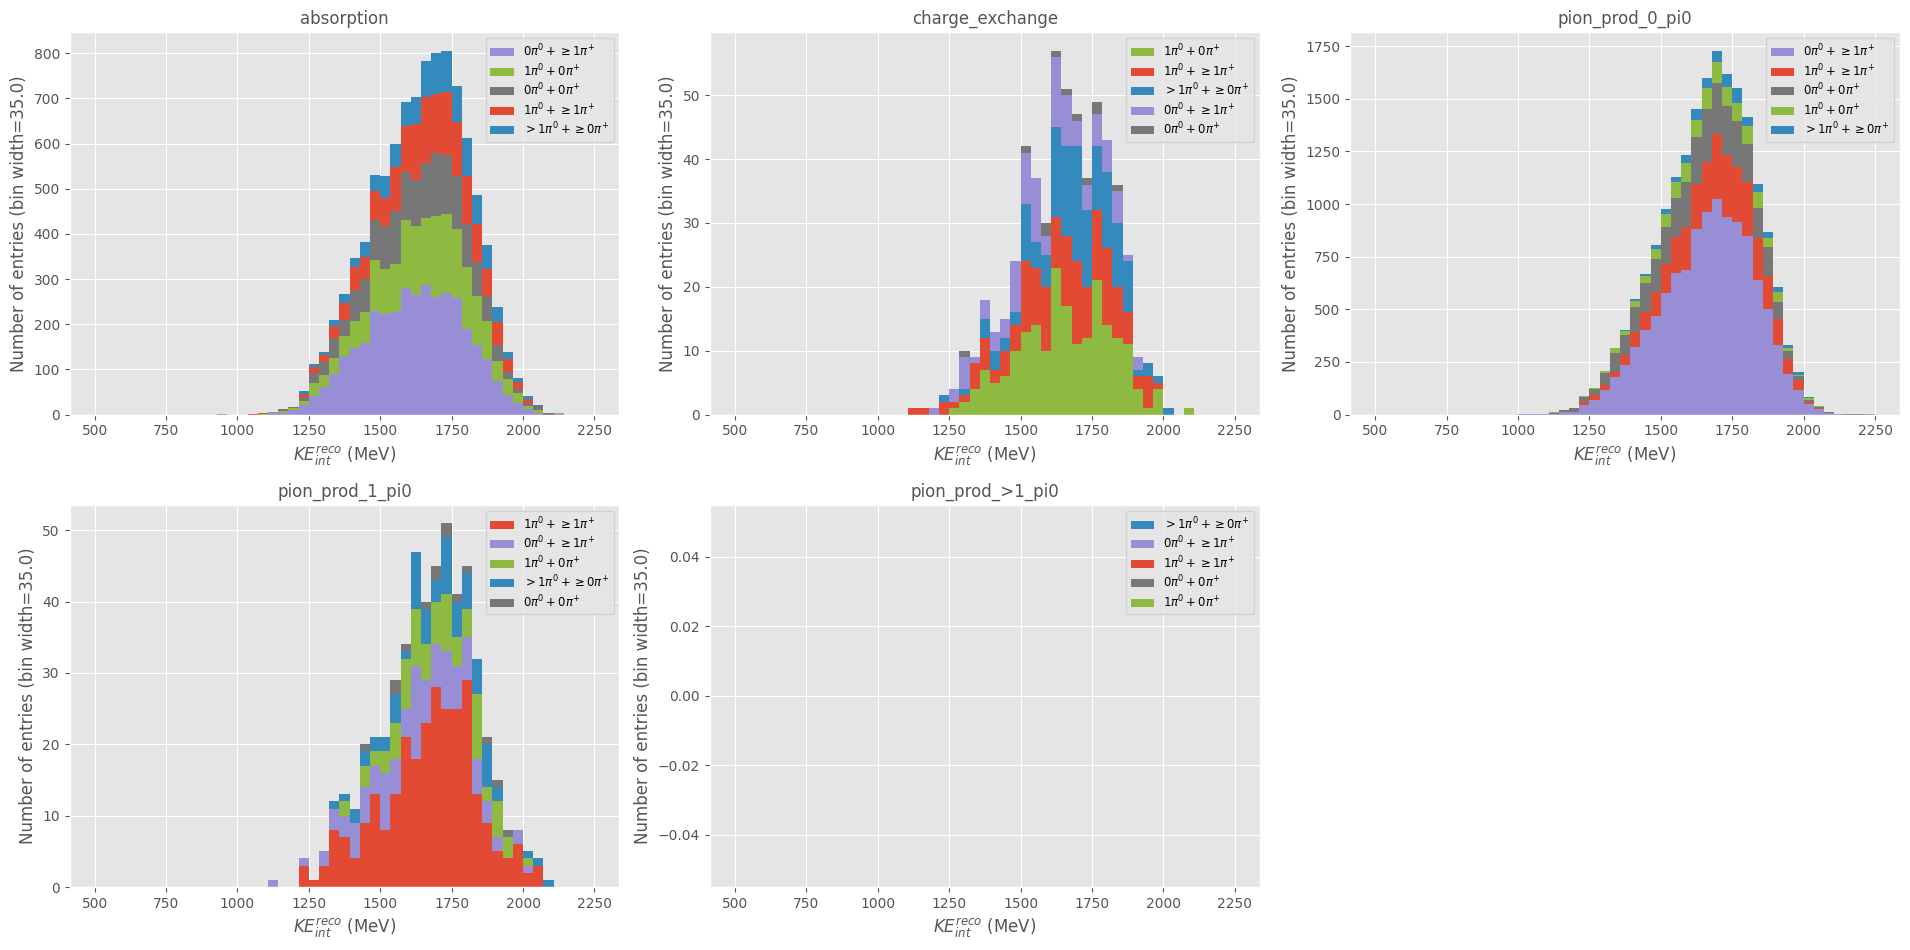

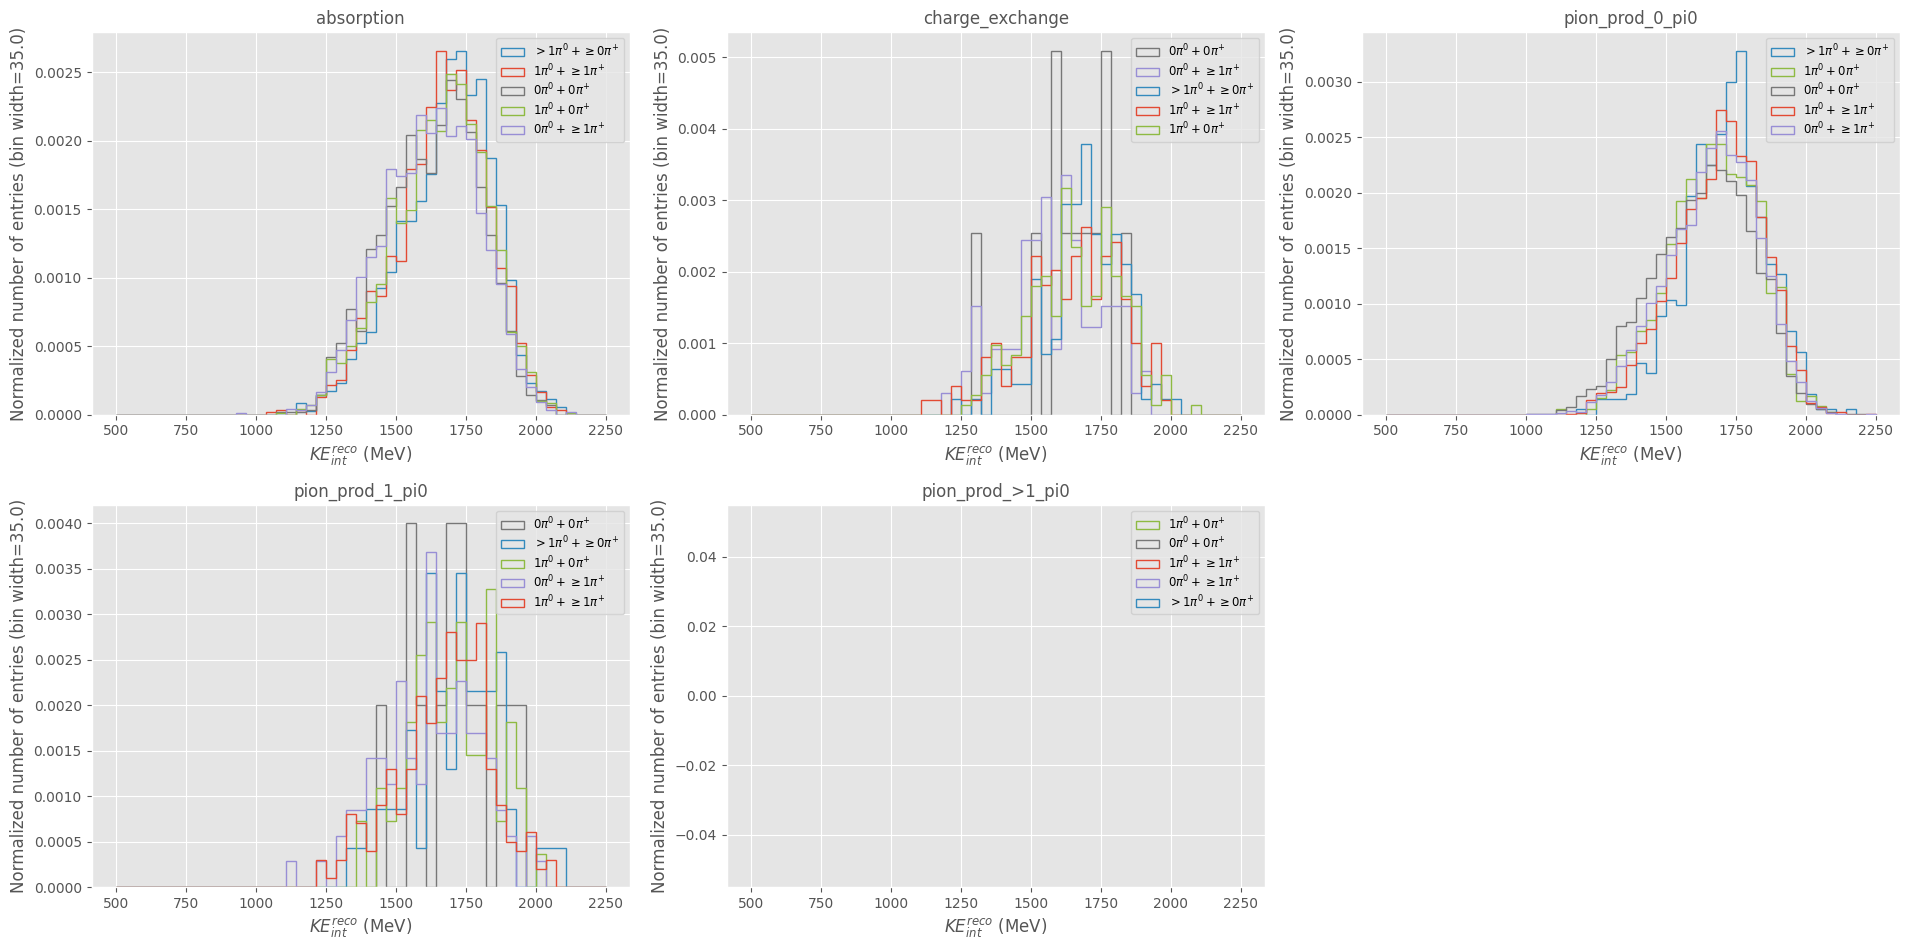

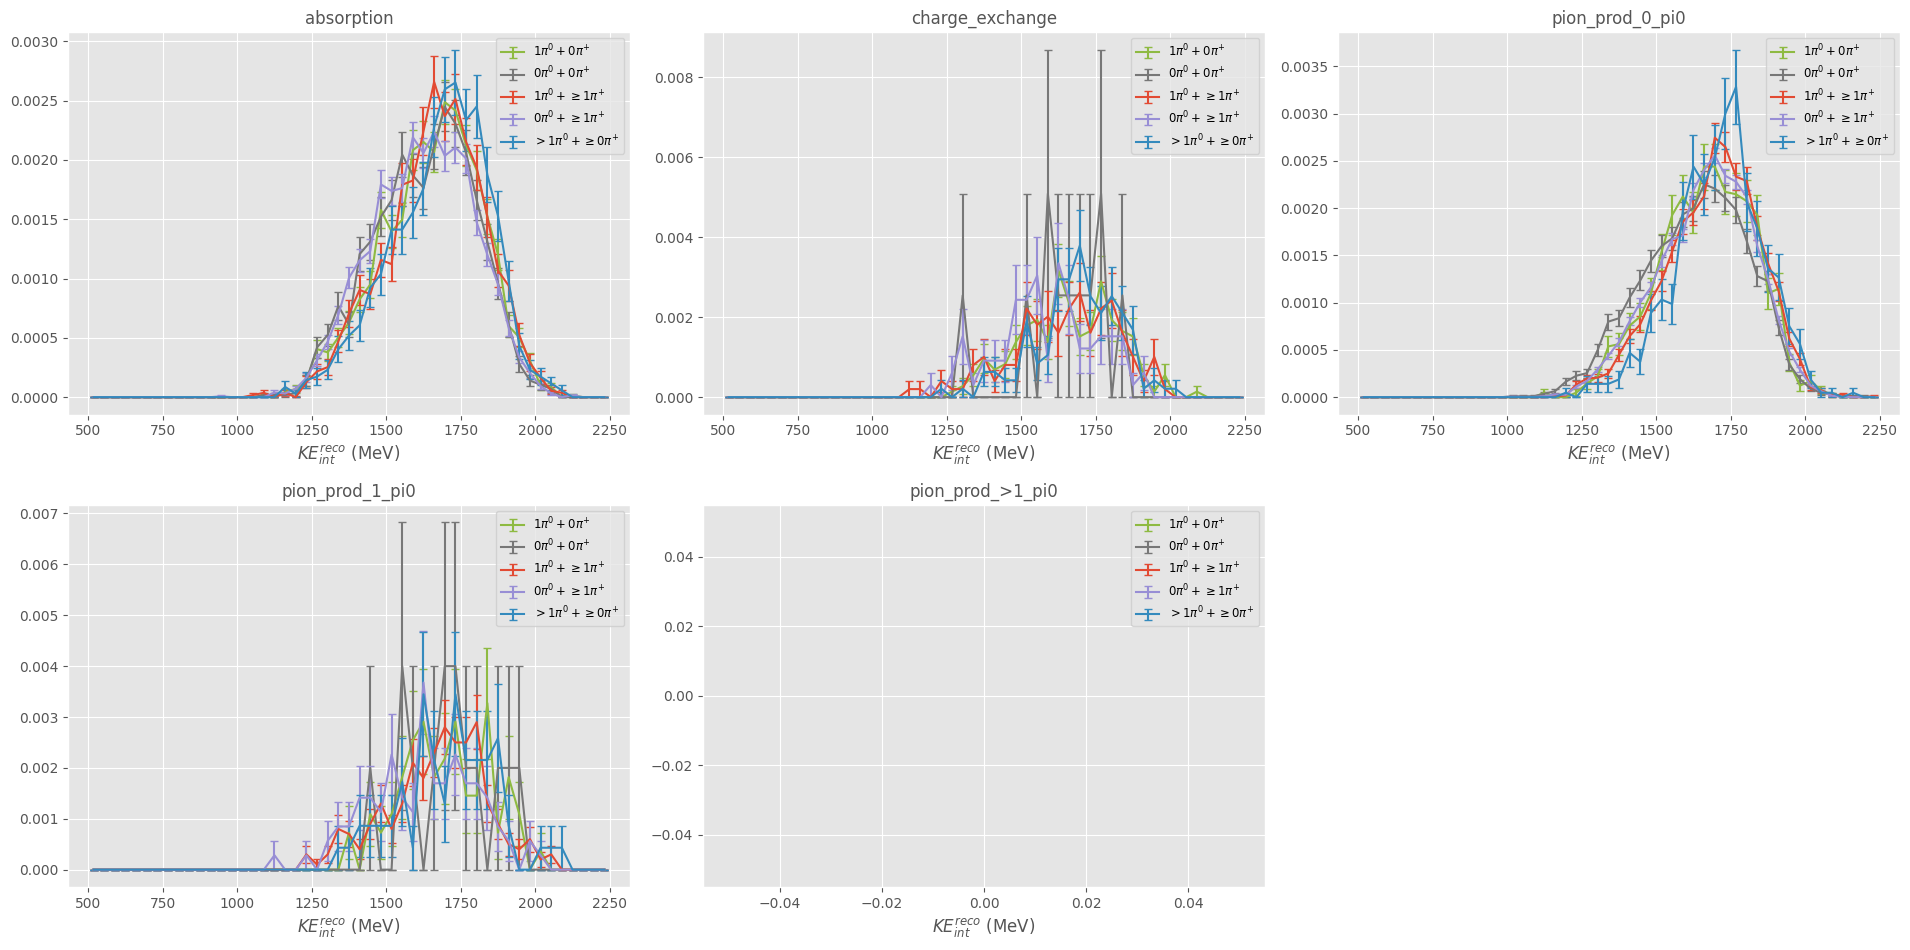

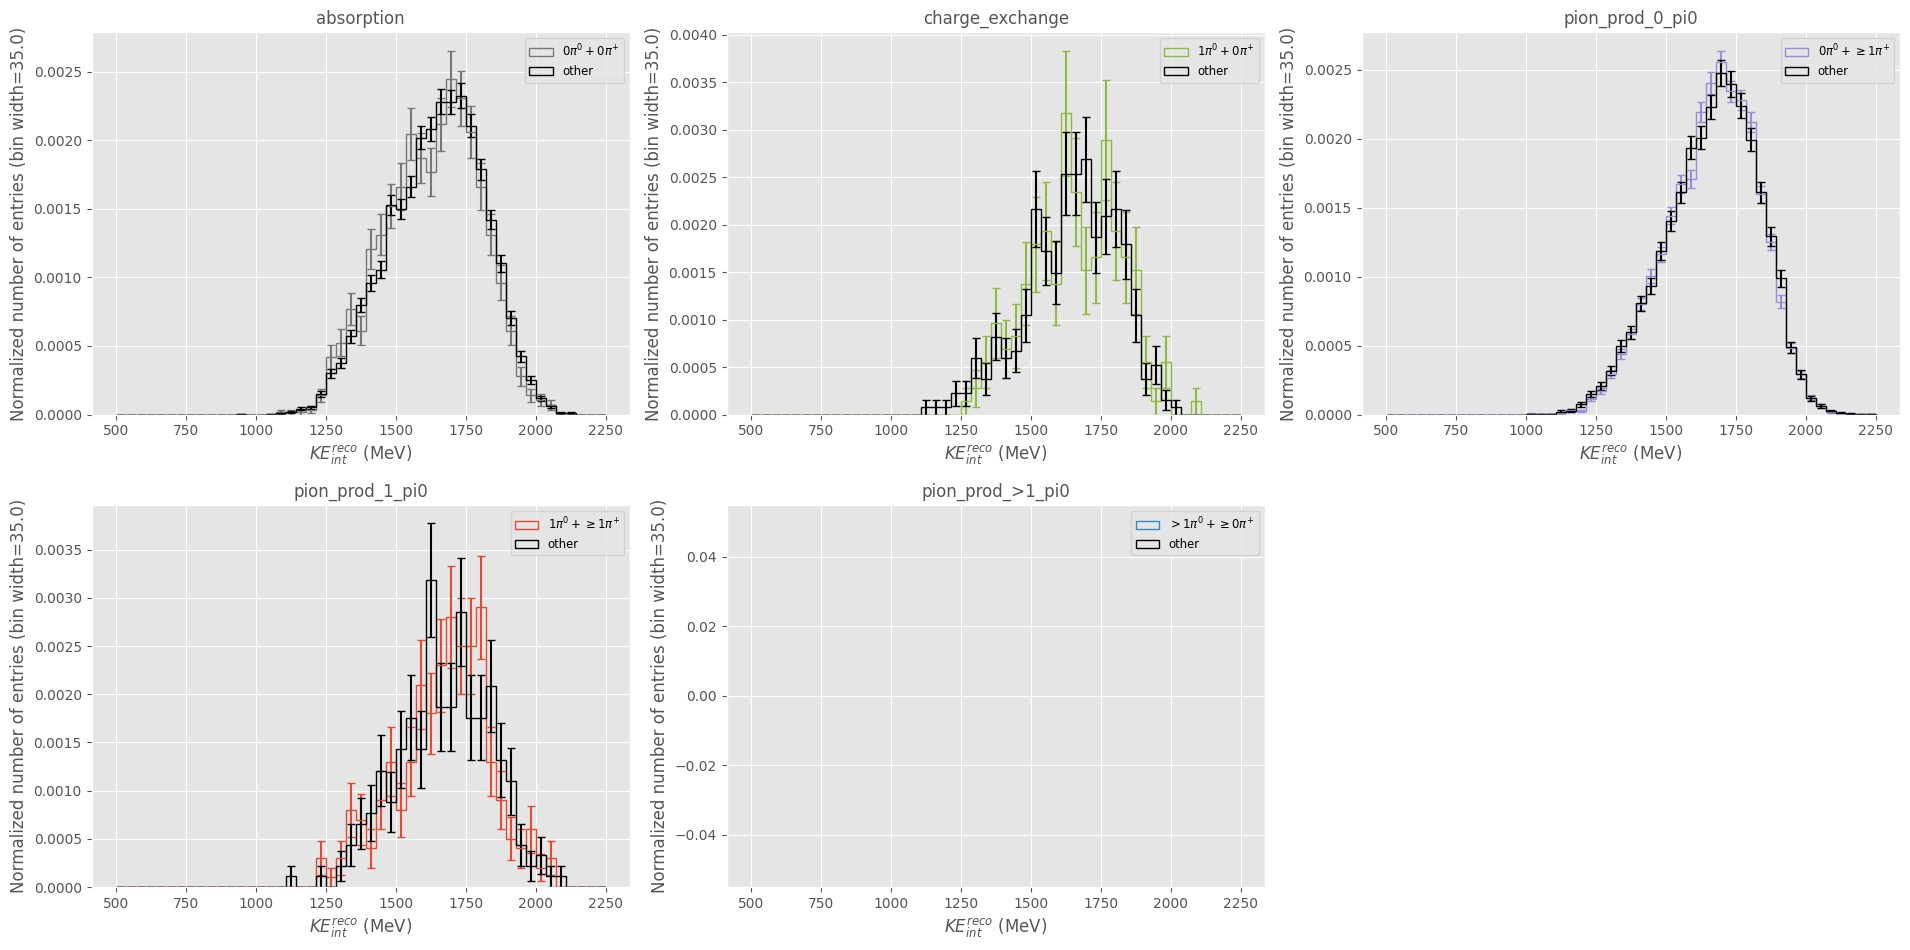

In [29]:
PlotInRegions(quantities["KE_int"], regions, bins["KE_int"], ranges["KE_int"], labels["KE_int"], stacked = True, norm = False, blind = True)
PlotInRegions(quantities["KE_int"], regions, bins["KE_int"], ranges["KE_int"], labels["KE_int"], stacked = False, norm = True, blind = True)
PlotTaggedNormalisedError(quantities["KE_int"], regions, bins["KE_int"], ranges["KE_int"], labels["KE_int"])
PlotSingleTaggedNormalisedError(quantities["KE_int"], regions, bins["KE_int"], ranges["KE_int"], labels["KE_int"])